<a href="https://colab.research.google.com/github/sgami444/Spotify-country-wise-trends-Data-mining/blob/main/Bisecting_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, pandas as pd, random
from matplotlib import pyplot as plt 
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from IPython.display import display


In [ ]:
def pca(X,k): 
    eigenValues, eigenVectors = np.linalg.eig(np.cov(X.T))
    eigenVectorsSorted = eigenVectors[:,(np.argsort(-eigenValues))]
    X_Transformed = (eigenVectorsSorted.T[:k]).T
    X_PCA = np.real(X.dot(X_Transformed))
    return X_PCA

def getDistanceFromCentres(arr, centres):
    distanceList = []
    for i in range(0, len(centres)):
        distanceVector = np.sqrt(((arr-centres[i,:])**2).sum(axis = 1))
        distanceList.append(distanceVector)        
    return np.array(distanceList).T

def getNearestCluster(arr):
    return np.array([np.argmin(i) for i in arr])

def getSSE(arr, clusterLabels,  clusters):
    clusterSSE  = []
    for i in range(0, len(clusters)):
        tArr = arr[clusterLabels == i]
        clusterSSE.append(sum(((tArr - clusters[i])**2).sum(axis = 0)))
    return clusterSSE

def get_lable_with_max_sse(lable_mse):
    max_key = list(lable_mse.keys())[0]
    for key in lable_mse:
        if lable_mse[max_key][0] < lable_mse[key][0]:
            max_key = key
    return(max_key)

def kmeansDef(kArr, clusters  = 2, no_of_iterations = 10):    
    clusterCentres = kArr[random.sample(range(kArr.shape[0]), clusters)]
    distancesFromCentres = getDistanceFromCentres(kArr, clusterCentres)     
    clusterLabels = getNearestCluster(distancesFromCentres)
    while (no_of_iterations>0):
        i = 0
        for i in range(clusters):
            clusterCentres[i] = kArr[clusterLabels == i].mean(axis=0) 
        distancesFromCentres = getDistanceFromCentres(kArr, clusterCentres)
        clusterLabels = getNearestCluster(distancesFromCentres)
        no_of_iterations -= 1
    clusterSSE  = getSSE(kArr, clusterLabels, clusterCentres)
    return (clusterLabels, clusterCentres, clusterSSE)  

def biSectingKmeans(bArr, bClusters  = 2, no_of_iterations = 10):
    clusterLabelList, clusterCentres, sse = kmeansDef(bArr, clusters  = 2, no_of_iterations = no_of_iterations)
    lable_mse = {0:[sse[0], clusterCentres[0]], 1:[sse[1], clusterCentres[1]]}
    if( bClusters == 2):
        return clusterLabelList, np.array(clusterCentres)
    offset = 2
    while(len(lable_mse) < bClusters):
        maxSSECLusterIndex = get_lable_with_max_sse(lable_mse)
        del lable_mse[maxSSECLusterIndex]       
        curr_clusterLabelList, curr_clusterCentres, curr_sse = kmeansDef(bArr[clusterLabelList == maxSSECLusterIndex], clusters  = 2, no_of_iterations = no_of_iterations)
        lable_mse[offset] = [curr_sse[0], curr_clusterCentres[0]]
        lable_mse[offset+1] = [curr_sse[1], curr_clusterCentres[1]]
        j = 0
        for i in range(len(clusterLabelList)):
            if clusterLabelList[i] == maxSSECLusterIndex:
                clusterLabelList[i] = curr_clusterLabelList[j] + offset
                j += 1
            if(j > len(curr_clusterLabelList)):
                break
        offset += 2    
    uniqueLabels = lable_mse.keys()   
    labelMap = {i: j for i,j in zip(range(len(clusterLabelList)), uniqueLabels)}
    labelMapRev = {j: i for i,j in zip(range(len(clusterLabelList)), uniqueLabels)}    
    clusterLabelList = [labelMapRev.get((clusterLabelList[i])) for i in range(len(clusterLabelList)) ]
    centroidPosList = np.array([list(lable_mse.get(labelMap.get(i))[1]) for i in range(len(labelMap)) ])
    # bSSEList = sum([lable_mse.get(labelMap.get(i))[0] for i in range(len(labelMap)) ])
    # return (clusterLabelList, centroidPosList, bSSEList)
    return (clusterLabelList, centroidPosList)

In [ ]:
# Feature selection
rawDf = pd.read_pickle('Resources\SourceData\\new_data.pkl')
featureList = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
# featureList = ['energy','acousticness']

rawSliceDf = rawDf[featureList]
rawSliceColsFilteredDf = rawSliceDf.values

# Imputation
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(rawSliceColsFilteredDf[:, :])
rawSliceColsFilteredDf[:,:] = imputer.transform(rawSliceColsFilteredDf[:,:])

# Normalization
stddevs = np.std(rawSliceColsFilteredDf,axis=0)+1e-6
preprocessedDF_NP = rawSliceColsFilteredDf/stddevs

# Dataframes
preprocessedDF_PD =  pd.DataFrame(preprocessedDF_NP, columns = featureList)

In [ ]:
selfImplementationSilhouetteScoreList = []
for n_clusters in range(2,15):
    clusters, centroids = biSectingKmeans(bArr = preprocessedDF_NP, bClusters = n_clusters)
    selfImplementationSilhouetteScoreList.append(silhouette_score(preprocessedDF_NP, clusters))
print(selfImplementationSilhouetteScoreList)  

[0.2850563512637338, 0.29904091513923453, 0.3409569166849117, 0.3436092783535796, 0.3389403307964387, 0.3172821975884285, 0.33197348395185733, 0.2632725078149565, 0.263875240726526, 0.2668786025158253, 0.25954527795165777, 0.25532790783378406, 0.24753442214603727]


In [ ]:
selfImplementationSilhouetteScoreListKmeans = []
libraryImplementationSilhouetteScoreListKmeans = []

for nClusters in range(2,15):
    clustersManual, centroids, _ = kmeansDef(preprocessedDF_NP, clusters  = nClusters, no_of_iterations = 50)
    scoreManual = silhouette_score(preprocessedDF_NP, clustersManual)
    kmeans = KMeans(n_clusters = nClusters, random_state=0).fit(preprocessedDF_NP)

    clustersLibrary = kmeans.labels_
    scoreLibrary = silhouette_score(preprocessedDF_NP, clustersLibrary)
    selfImplementationSilhouetteScoreListKmeans.append(scoreManual)
    libraryImplementationSilhouetteScoreListKmeans.append(scoreLibrary)

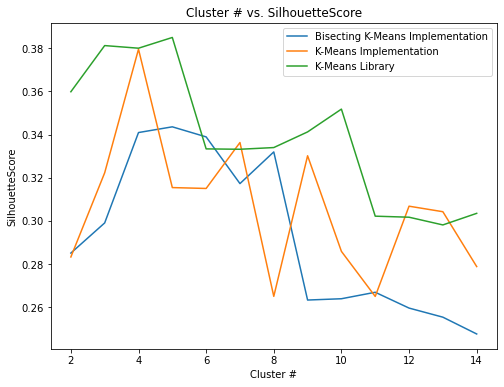

In [ ]:
plt.figure(figsize =(8, 6))
plt.plot( range(2,15), selfImplementationSilhouetteScoreList, label = "Bisecting K-Means Implementation")
plt.plot( range(2,15), selfImplementationSilhouetteScoreListKmeans, label = "K-Means Implementation")
plt.plot( range(2,15), libraryImplementationSilhouetteScoreListKmeans, label = "K-Means Library")
plt.title('Cluster # vs. SilhouetteScore')
plt.xlabel('Cluster #')
plt.ylabel('SilhouetteScore')
plt.legend()
plt.show() 

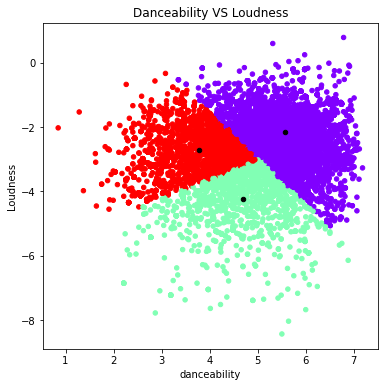

In [ ]:
# clusters, centroids, _ = kmeans(sArr,3,100)
clusters, centroids = biSectingKmeans(preprocessedDF_NP,3,20)
plt.figure(figsize =(6, 6))
plt.scatter(preprocessedDF_NP[:,0], preprocessedDF_NP[:,1], s = 20, c = clusters, cmap ='rainbow')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
plt.title('Danceability VS Loudness')
plt.xlabel('danceability')
plt.ylabel('Loudness')
plt.show()

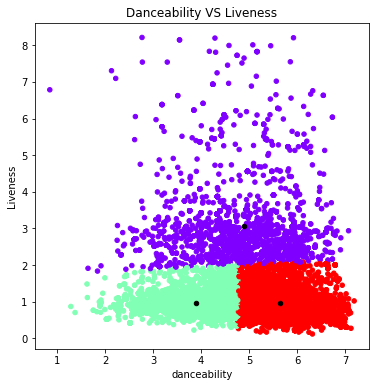

In [ ]:
# clusters, centroids, _ = kmeans(sArr,3,100)
clusters, centroids = biSectingKmeans(preprocessedDF_NP,3,20)
plt.figure(figsize =(6, 6))
plt.scatter(preprocessedDF_NP[:,0], preprocessedDF_NP[:,1], s = 20, c = clusters, cmap ='rainbow')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
plt.title('Danceability VS Liveness')
plt.xlabel('danceability')
plt.ylabel('Liveness')
plt.show()

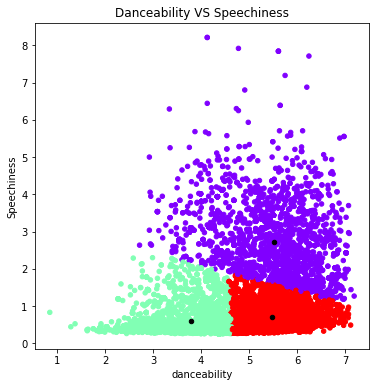

In [ ]:
clusters, centroids = biSectingKmeans(preprocessedDF_NP,3,20)
plt.figure(figsize =(6, 6))
plt.scatter(preprocessedDF_NP[:,0], preprocessedDF_NP[:,1], s = 20, c = clusters, cmap ='rainbow')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
plt.title('Danceability VS Speechiness')
plt.xlabel('danceability')
plt.ylabel('Speechiness')
plt.show()

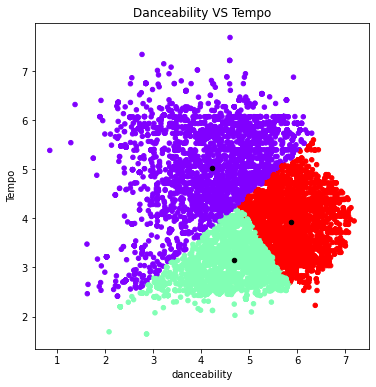

In [ ]:
clusters, centroids = biSectingKmeans(preprocessedDF_NP,3,20)
plt.figure(figsize =(6, 6))
plt.scatter(preprocessedDF_NP[:,0], preprocessedDF_NP[:,1], s = 20, c = clusters, cmap ='rainbow')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
plt.title('Danceability VS Tempo')
plt.xlabel('danceability')
plt.ylabel('Tempo')
plt.show()

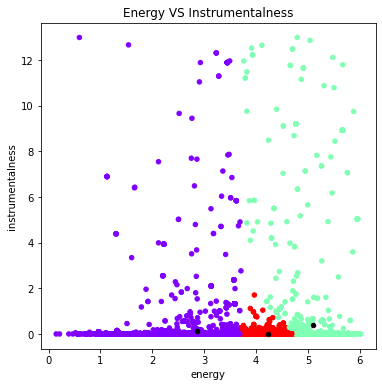

In [ ]:
clusters, centroids = biSectingKmeans(preprocessedDF_NP,3,20)
plt.figure(figsize =(6, 6))
plt.scatter(preprocessedDF_NP[:,0], preprocessedDF_NP[:,1], s = 20, c = clusters, cmap ='rainbow')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
plt.title('Energy VS Instrumentalness')
plt.xlabel('energy')
plt.ylabel('instrumentalness')
plt.show()

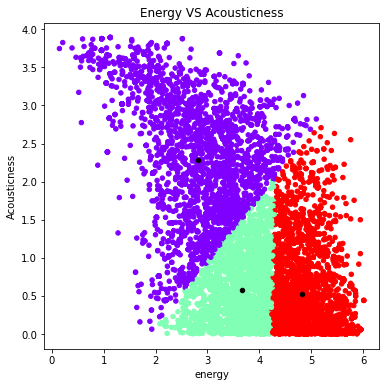

In [ ]:
clusters, centroids = biSectingKmeans(preprocessedDF_NP,3,20)
plt.figure(figsize =(6, 6))
plt.scatter(preprocessedDF_NP[:,0], preprocessedDF_NP[:,1], s = 20, c = clusters, cmap ='rainbow')
plt.scatter(centroids[:,0] , centroids[:,1] , s = 20, color = 'k')
plt.title('Energy VS Acousticness')
plt.xlabel('energy')
plt.ylabel('Acousticness')
plt.show()

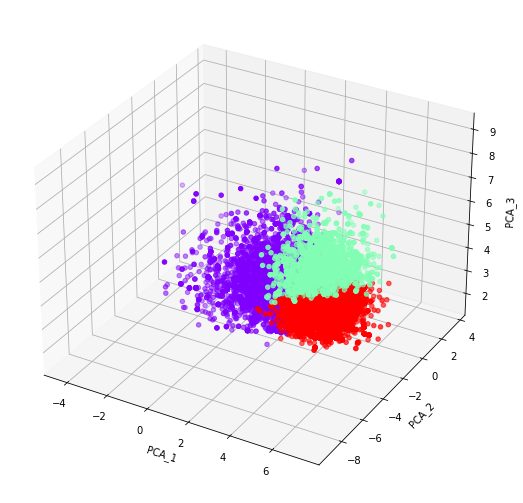

In [ ]:
preprocessedDF_NP_PCA = pca(preprocessedDF_NP, 3)
clusters, centroids = biSectingKmeans(preprocessedDF_NP_PCA, 3,50)
plt.figure(figsize =(9,9))
ax = plt.axes(projection='3d')
ax.scatter3D(preprocessedDF_NP_PCA[:,0], preprocessedDF_NP_PCA[:,1], preprocessedDF_NP_PCA[:,2], c = clusters, cmap='rainbow')
ax.scatter3D(centroids[:,0] , centroids[:,1] ,centroids[:,2],  s = 40, color = 'k', cmap='k')
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')
plt.show()

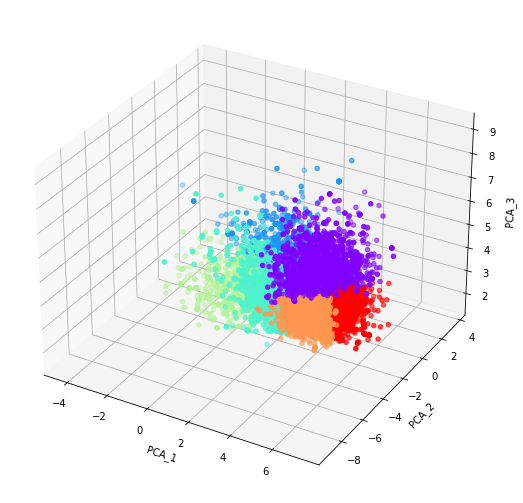

In [ ]:
preprocessedDF_NP_PCA = pca(preprocessedDF_NP, 3)
clusters, centroids = biSectingKmeans(preprocessedDF_NP_PCA, 6,50)
plt.figure(figsize =(9,9))
ax = plt.axes(projection='3d')
ax.scatter3D(preprocessedDF_NP_PCA[:,0], preprocessedDF_NP_PCA[:,1], preprocessedDF_NP_PCA[:,2], c = clusters, cmap='rainbow')
ax.scatter3D(centroids[:,0] , centroids[:,1] ,centroids[:,2],  s = 40, color = 'k', cmap='k')
ax.set_xlabel('PCA_1')
ax.set_ylabel('PCA_2')
ax.set_zlabel('PCA_3')
plt.show()